## Pontificia Universidad Javeriana

*Autores:*
- Diego Alejandro Jara Rojas  
- Juan Felipe González Quintero  
- Tomás Felipe Guerra Hernández  
- Isaías Acosta Herrera  

*Fecha de Inicio:* 10 - 10 - 2025  
*Fecha de Finalización:* 17 - 10 - 2025  

---

## **Proyecto**
*Análisis de los factores socioeconómicos y delictivos asociados a los arrestos en la ciudad de Nueva York mediante técnicas de procesamiento de Big Data.*

---

## **Problemática**
El aumento de arrestos en ciertos distritos de Nueva York plantea la necesidad de analizar qué factores pueden estar influyendo en esta tendencia.  
Mediante la integración de datos sobre pobreza, criminalidad en escuelas y registros de arrestos, se busca identificar patrones y correlaciones que permitan entender si la desigualdad socioeconómica y la violencia escolar tienen un impacto significativo en las tasas de arrestos.

---

## **Objetivo**
Realizar un análisis exploratorio y predictivo sobre los arrestos en Nueva York a partir de datos públicos de pobreza, crímenes en escuelas y reportes policiales, con el fin de determinar posibles relaciones entre las condiciones sociales y los niveles de criminalidad y detención.

---

## **Metodología**

1. *Importación de datos desde el cluster*  
   Carga de datasets en distintos formatos (CSV, Parquet) provenientes de fuentes oficiales del estado de Nueva York.  

2. *Preprocesamiento y limpieza de datos*  
   Estandarización de valores, manejo de nulos, combinación de bases de datos y normalización de variables.  

3. *Análisis exploratorio de datos (EDA)*  
   Cálculo de medidas estadísticas y visualización de distribuciones para identificar tendencias por distrito, tipo de crimen, nivel de pobreza y número de arrestos.  

4. *Modelado y correlación de variables*  
   Aplicación de modelos estadísticos y de aprendizaje automático (como regresión lineal y modelos de correlación múltiple) para evaluar relaciones entre pobreza, crimen y arrestos.  

5. *Evaluación e interpretación*  
   Análisis de resultados y visualización de patrones espaciales y sociales relevantes para comprender los factores más influyentes en la tasa de arrestos. (Ver documento)

6. *Fuentes de referencia*  
   - Open Data NYC  
   - Department of Education NYC  
   - NYPD Arrest Data Reports  
   - Artículos y estudios previos sobre desigualdad y criminalidad urbana.

In [1]:
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
!which python

~/miniconda3/bin/python


#### Verificamos que estamos utilizando la versión de Python instalado en el cluster mediante Conda.

In [3]:
import os

os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#Bibliotecas especializadas
from pylab import *

In [5]:
#Bibliotecas de Contexto PySpark

#Busqueda e inicializacion para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

In [6]:
### Se crea una sesión para jacer el contexto de procesamiento desde mi Cuota del Cluster
from pyspark import SparkConf
## Configuracion de la cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

## Se levanta la configuración de mi cuota
configura.setAppName("NY_Escuelas_Proyecto")

sparkSPE = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=sparkSPE.sparkContext, sparkSession=sparkSPE)

contextoSparkSPE = sparkSPE.sparkContext.getOrCreate()

print("Sesion Cluster: NY_Escuelas_Proyecto")
sparkSPE

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 23:13:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesion Cluster: NY_Escuelas_Proyecto


# **2.- Carga de datos desde el cluster**

In [7]:
### Como estoy en un servidor que no es mio, y ni siquiera lo he realizado ni IMPLEMENTADO
### Requiero saber que configuración de hardware me han dado a mi cuota de sesión
### Adicional como cientifico que soy, requiero tambien como hacer un cluster para saber todo eso de implementación de un cluster,

cantCPUS = sparkSPE._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion Spark09: {cantCPUS}" )
print(sparkSPE.sparkContext.getConf().getAll())

Cantidad de CPU's en mi sesion Spark09: 1
[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.driver.host', 'NPDG16'), ('spark.app.id', 'local-176110

### Acceso al Cluster de Almacenamiento (Almacen)

In [8]:
## Se carga el CSV de Pobreza en nueva york como OBJETO DATAFRAME PySpark

### Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV
df00 = sparkSPE.read.csv("/almacen/proyecto/2017_-_2018_Schools_NYPD_Crime_Data_Report_20251009.csv", header = True, inferSchema=True)

df00.show(5)

+----+-------------+------+--------------------+-------------+-------------------+-------+--------------------------+-------------+--------------------+---------+--------------------+-------+-----+--------+------+-----+--------+--------+------------+----------+-------------+-----------+----------+------------------------+
|  ID|Building Code|   DBN|       Location Name|Location Code|            Address|Borough|Geographical District Code|     Register|       Building Name|# Schools| Schools in Building|Major N|Oth N|NoCrim N|Prop N|Vio N|ENGroupA|  RangeA|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|New Georeferenced Column|
+----+-------------+------+--------------------+-------------+-------------------+-------+--------------------------+-------------+--------------------+---------+--------------------+-------+-----+--------+------+-----+--------+--------+------------+----------+-------------+-----------+----------+------------------------+
| 646|         M019|01M301|T

## **3. - Análisis y Preparación de Datos**
Se presentan datos (csv) ------

- Tipos de datos: coherencia de tipo de datos, transformación.
- Columnas: conocimiento de las columnas, eliminación.
- Análisis de taso nulos o imposibles: conocimiento.

In [9]:
## Conocimiento de las columnas
df00.columns

['ID',
 'Building Code',
 'DBN',
 'Location Name',
 'Location Code',
 'Address',
 'Borough',
 'Geographical District Code',
 'Register',
 'Building Name',
 '# Schools',
 'Schools in Building',
 'Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'ENGroupA',
 'RangeA',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N',
 'New Georeferenced Column']

#### Descripción de las columnas más importantes
- **Borough:** Distrito de la escuela donde ocurrío el incidente.
- **Major N:** Número de crímenes mayores reportados en la escuela.
- **Oth N:** Número de otros incidentes o delitos menores.
- **NoCrim N:** Número de incidentes no criminales.
- **Prop N:** Número de crímenes de propiedad.
- **Vio N:** Número de crímenes violentos
- **AvgOfMajor N:** Promedio de crímenes mayores.
- **AvgOfOth N:** Promedio de otros incidentes menores.
- **AvgOfNoCrim N:** Promedio de incidentes no criminales.
- **AvgOfProp N:** Promedio de delitos contra la propiedad.
- **AvgOfVio N:** Promedio de crímenes violentos.

In [10]:
#Se procede a identificar los tipos de datos originales del conjunto de datos de Arrestos
df00.dtypes

[('ID', 'int'),
 ('Building Code', 'string'),
 ('DBN', 'string'),
 ('Location Name', 'string'),
 ('Location Code', 'string'),
 ('Address', 'string'),
 ('Borough', 'string'),
 ('Geographical District Code', 'int'),
 ('Register', 'string'),
 ('Building Name', 'string'),
 ('# Schools', 'int'),
 ('Schools in Building', 'string'),
 ('Major N', 'string'),
 ('Oth N', 'string'),
 ('NoCrim N', 'string'),
 ('Prop N', 'string'),
 ('Vio N', 'string'),
 ('ENGroupA', 'string'),
 ('RangeA', 'string'),
 ('AvgOfMajor N', 'string'),
 ('AvgOfOth N', 'string'),
 ('AvgOfNoCrim N', 'string'),
 ('AvgOfProp N', 'string'),
 ('AvgOfVio N', 'string'),
 ('New Georeferenced Column', 'string')]

Como se puede evidenciar, no existen variables en este conjunto de datos a las que sea necesario aplicarles una transformación en primera instancia, con lo que este paso será omitido. Sin embargo, más adelante se realizarán procesos de estandarización de algunas variables para que estas coincidan y puedan relacionarse de mejor forma con los otros conjuntos de datos utilizados en este estudio (Pobreza e Arrestos de Nueva York).

In [11]:
#Se hace una descripción estadísitca de los parámetros/variables del conjunto de datos para una exploración inicial
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+-----------------+
|summary|               ID|
+-------+-----------------+
|  count|             1919|
|   mean|973.5216258467952|
| stddev|565.6179908754177|
|    min|                1|
|    max|             1954|
+-------+-----------------+

+-------+-------------+
|summary|Building Code|
+-------+-------------+
|  count|         1919|
|   mean|         NULL|
| stddev|         NULL|
|    min|         K001|
|    max|         XAJF|
+-------+-------------+

+-------+-------------+
|summary|          DBN|
+-------+-------------+
|  count|         1646|
|   mean|         NULL|
| stddev|         NULL|
|    min|       01M015|
|    max|PS 161(BRONX)|
+-------+-------------+

+-------+--------------------+
|summary|       Location Name|
+-------+--------------------+
|  count|                1919|
|   mean|                NULL|
| stddev|                NULL|
|    min|              07X161|
|    max|Young Women's Lea...|
+-------+--------------------+

+-------+-------------+
|summary|

## **Exploración de valores nulos en los datos**

En esta sección usamos diferentes consultas para **revisar si en el conjunto de datos existen datos nulos o con valores imposibles** para poder realizar su limpieza, ya de no realizarse, podría verse afectada la generación de visualizaciones gráficas y las conclusiones a sacar de este estudio.

In [12]:
#Rastreamos la cantidad de valores nulos o imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+---+-------------+---+-------------+-------------+-------+-------+--------------------------+--------+-------------+---------+-------------------+-------+-----+--------+------+-----+--------+------+------------+----------+-------------+-----------+----------+------------------------+
| ID|Building Code|DBN|Location Name|Location Code|Address|Borough|Geographical District Code|Register|Building Name|# Schools|Schools in Building|Major N|Oth N|NoCrim N|Prop N|Vio N|ENGroupA|RangeA|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|New Georeferenced Column|
+---+-------------+---+-------------+-------------+-------+-------+--------------------------+--------+-------------+---------+-------------------+-------+-----+--------+------+-----+--------+------+------------+----------+-------------+-----------+----------+------------------------+
|  0|            0|273|            0|          269|      0|      0|                         0|       0|          902|        0|               

Con esto se comprueba que **efectivamente existen varias columnas con datos nulos** por lo que para generar un dataframe para realizar las visualizaciones del conjunto de datos, **conservaremos únicamente** los datos sin estos registros (más adelante se eliminarán varias de las columnas que tienen datos nulos ya que no poseen información útil para el estudio)

# **4. Eliminación de columnas no relevantes**


Con esto se comprueba que **efectivamente existen varias columnas con datos nulos** por lo que para generar un dataframe para realizar las visualizaciones del conjunto de datos, **conservaremos únicamente** los datos sin estos registros (más adelante se eliminarán varias de las columnas que tienen datos nulos ya que no poseen información útil para el estudio)

Para este estudio se contempla hacer uso de algunas de las columnas del conjunto de datos de arrestos, por lo que se procede a eliminar aquellas que no representan información importante.

In [13]:
#Eliminamos las columnas que no son relevantes para el estudio
df01 = df00.drop('ID','Building Code','Geographical District Code','Location Name','Location Code','DBN','Address','Register','Building Name','# Schools','Schools in Building','ENGroupA','RangeA','New Georeferenced Column')
#Mostramos las primeras 10 filas para verificar que los cambios hayan sido aplicados
df01.show(30)

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      M|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      M|      0|    0|       3|     0|    0|        0.25|      0.88|         1.69|       0.57|      0.45|
|      K|      1|    1|       0|     2|    0|        0.38|      1.52|         3.88|       0.83|      0.91|
|      Q|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      M|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      M|      1|   11|       8|     6|    4|        0.25|      1.03|         2.22|       0.55|      0.58|
|      M|      1|    4|       1|     

Las columnas seleccionadas para continuar con el estudio se justifican a continuación:

- **Borough:** Permite relacionar los datos de las escuelas con los de pobreza y arrestos, que también se reportan por borough.
- **Major N:** Indicador de criminalidad seria dentro de cada escuela.
- **Oth N:** Refleja la frecuencia de incidentes no mayores, complementando la categoría anterior.
- **NoCrim N:** Permite medir el nivel general de conflicto en la escuela, incluso si no llega a ser crimen.
- **Prop N:** Mide la afectación a la propiedad dentro del entorno escolar.
- **Vio N:** Es un indicador clave para medir la inseguridad violenta en el entorno escolar.
- **AvgOfMajor N:** Facilita la comparación entre distritos o boroughs sin sesgo por tamaño.
- **AvgOfOth N:** Complementa la visión general de seguridad escolar promedio.
- **AvgOfNoCrim N:** Permite comparar niveles de conflicto escolar general entre zonas.
- **AvgOfProp N:** Útil para estudiar tendencias en crímenes de propiedad a nivel agregado.
- **AvgOfVio N:** Variable clave para correlacionar con niveles de pobreza o arrestos en el mismo borough o distrito.

In [14]:
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      0|      0|    0|       0|     0|    0|           0|         0|            0|          0|         0|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+



# **5. Estandarización de variables**

Con el proposito de relacionar los otros datasets se va a standarizar las variables que aparecen en los datasets. En este caso seria la variable Borough que aparece en los arrestos y en la pobreza ademas de este mismo dataset

In [15]:
#Importación de recursos extra de pyspark
from pyspark.sql.functions import when, col

#Se asignan los reemplazos de cada uno de los valores de la columna "Borough" para que estos coincidan con los de los demás datasets
df01 = (
    df01.withColumn(
        "Borough",
        when(col("Borough") == "X", 1)
        .when(col("Borough") == "K", 2)
        .when(col("Borough") == "M", 3)
        .when(col("Borough") == "Q", 4)
        .when(col("Borough") == "R", 5)
        .otherwise(None)  
    )
)

#Verificamos que los cambios hayan sido aplicados al dataframe
df01.show(10)

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|      0|    0|       3|     0|    0|        0.25|      0.88|         1.69|       0.57|      0.45|
|      2|      1|    1|       0|     2|    0|        0.38|      1.52|         3.88|       0.83|      0.91|
|      4|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|      1|   11|       8|     6|    4|        0.25|      1.03|         2.22|       0.55|      0.58|
|      3|      1|    4|       1|     

## **Tratamiento de datos nulos**
Como en este caso la tabla que tenemos no tiene valores nulos no es necesario sobreescribir los nulos.

In [16]:
#Se hace el conteo de datos nulos 
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      0|      0|    0|       0|     0|    0|           0|         0|            0|          0|         0|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+



In [17]:
# Se sobreescribe el dataframe
df01.write.mode("overwrite").parquet("/almacen/proyecto/parquet/df_crimenesEscuela.parquet")
df01.show(5)

[Stage 89:>                                                         (0 + 1) / 1]

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|      0|    0|       3|     0|    0|        0.25|      0.88|         1.69|       0.57|      0.45|
|      2|      1|    1|       0|     2|    0|        0.38|      1.52|         3.88|       0.83|      0.91|
|      4|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
only showing top 5 rows



# **Visualización gráfica de datos**

/tmp/ipykernel_290549/2000787292.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


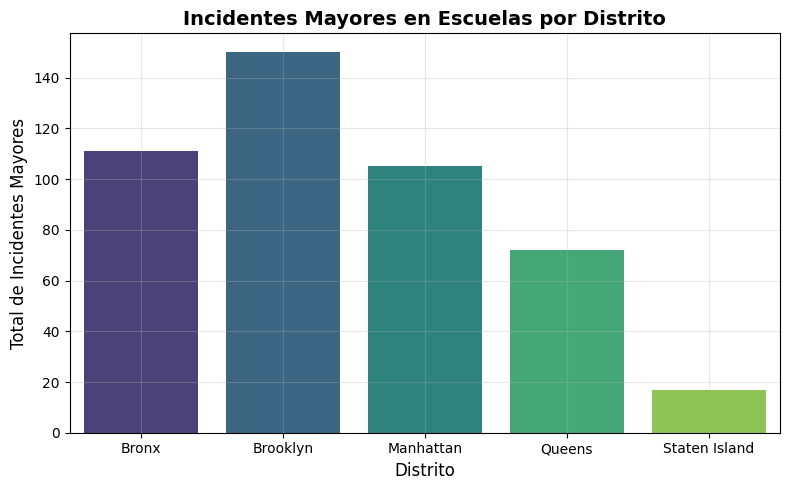

In [18]:
# Agrupar por Borough y sumar los incidentes mayores
df_major = (
    df01.groupBy("Borough")
        .agg(F.sum("Major N").alias("Total_Major_N"))
        .orderBy("Borough")
)

# Convertir a Pandas
df_major_pd = df_major.toPandas()

# Mapear los códigos numéricos a nombres de borough
borough_map = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Reemplazar los números por los nombres
df_major_pd["Borough"] = df_major_pd["Borough"].map(borough_map)

# Eliminar filas con Borough nulo
df_major_pd = df_major_pd.dropna(subset=["Borough"])

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_major_pd,
    x="Borough",
    y="Total_Major_N",
    palette="viridis"
)

plt.title("Incidentes Mayores en Escuelas por Distrito", fontsize=14, fontweight="bold")
plt.xlabel("Distrito", fontsize=12)
plt.ylabel("Total de Incidentes Mayores", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

save = '/almacen/proyecto/graficas_proyecto/grafica_incidentes_mayores_borough.png'
plt.savefig(save, dpi=300)
plt.close()



In [19]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, when, sum as _sum

df02 = df01.withColumn(
    "Total_Crimenes",
    col("Major N") + col("Oth N") + col("NoCrim N") + col("Prop N") + col("Vio N")
)

In [20]:
df_borough_total = (
    df02.groupBy("Borough")
        .agg(_sum("Total_Crimenes").alias("Crimenes_Totales"))
        .orderBy("Borough")
)

/tmp/ipykernel_290549/1266966588.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


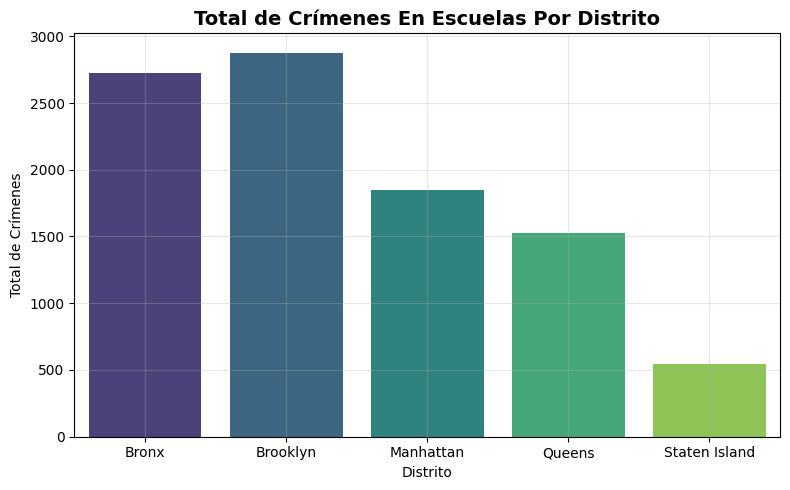

In [21]:
# Convertir a pandas
df_borough_pd = df_borough_total.toPandas()

# Mapear los códigos numéricos a nombres de borough
borough_map = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Reemplazar los números por los nombres
df_borough_pd["Borough"] = df_borough_pd["Borough"].map(borough_map)

# Eliminar filas con Borough nulo
df_borough_pd = df_borough_pd.dropna(subset=["Borough"])

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_borough_pd,
    x="Borough",
    y="Crimenes_Totales",
    palette="viridis"
)

plt.title("Total de Crímenes En Escuelas Por Distrito", fontsize=14, fontweight="bold")
plt.xlabel("Distrito")
plt.ylabel("Total de Crímenes")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

save2 = '/almacen/proyecto/graficas_proyecto/grafica_total_crimenes_borough.png'
plt.savefig(save2, dpi=300)
plt.close()

